In [9]:
# Task A – Determine flight path bounding box
import time
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd
import os

# --- Paths ---
pos_path = "20200910_BlakesOpening_site3_flight1z.pos"
gpkg_path = "uas_flight.gpkg"
layer_name = "flight_path"

t0 = time.perf_counter()

# --- Read .pos file ---
col_names = [
    "timestamp", "lat", "lon", "height_m",
    "Q", "Q_text", "sats",
    "SDNorth_m", "SDEast_m", "SDHeight_m", "StdDev_m"
]

df = pd.read_csv(
    pos_path,
    comment="%",        # skip RTKLIB header rows
    header=None,
    names=col_names,
    dtype={
        "lat": float, "lon": float, "height_m": float,
        "Q": "Int64", "sats": "Int64",
        "SDNorth_m": float, "SDEast_m": float, "SDHeight_m": float, "StdDev_m": float
    }
)

read_time = time.perf_counter() - t0

# Drop rows without coordinates
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# --- Create GeoDataFrame in WGS84 (EPSG:7844) and project to MGA2020 / Zone 55 (EPSG:7855) ---
gdf_wgs84 = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])],
    crs="EPSG:7844"
)
gdf = gdf_wgs84.to_crs("EPSG:7855")

# --- Bounding box + height range ---
minx, miny, maxx, maxy = gdf.total_bounds
min_h = float(np.nanmin(gdf["height_m"]))
max_h = float(np.nanmax(gdf["height_m"]))

# --- LineString and length ---
line = LineString(list(gdf.geometry.values))
line_gdf = gpd.GeoDataFrame(
    {"total_length_m": [line.length]},
    geometry=[line],
    crs=gdf.crs
)

# Save to GeoPackage
if os.path.exists(gpkg_path):
    os.remove(gpkg_path)
line_gdf.to_file(gpkg_path, layer=layer_name, driver="GPKG")

calc_time = time.perf_counter() - t0 - read_time

# --- Nicely formatted printouts ---
def fmt_m(x): return f"{x:,.3f} m"

print("A) Determine flight path bounding box — outputs")
print("------------------------------------------------")
print("Bounding Box (EPSG:7855):")
print(f"  Easting min:  {fmt_m(minx)}")
print(f"  Easting max:  {fmt_m(maxx)}")
print(f"  Northing min: {fmt_m(miny)}")
print(f"  Northing max: {fmt_m(maxy)}")
print("Heights:")
print(f"  Height min:   {fmt_m(min_h)}")
print(f"  Height max:   {fmt_m(max_h)}")
print("Timings:")
print(f"  Read .pos:          {read_time:.3f} s")
print(f"  Calculations total: {calc_time:.3f} s")
print(f"Total flight path length: {fmt_m(line.length)}")
print(f"GeoPackage written: {gpkg_path} (layer: {layer_name})")


A) Determine flight path bounding box — outputs
------------------------------------------------
Bounding Box (EPSG:7855):
  Easting min:  467,724.652 m
  Easting max:  468,410.536 m
  Northing min: 5,225,706.246 m
  Northing max: 5,226,080.720 m
Heights:
  Height min:   281.855 m
  Height max:   304.533 m
Timings:
  Read .pos:          0.077 s
  Calculations total: 0.871 s
Total flight path length: 3,663.539 m
GeoPackage written: uas_flight.gpkg (layer: flight_path)


0        0.029698
1        0.009220
2        0.009220
3        0.009220
4        0.009220
           ...   
14360    0.007810
14361    0.007810
14362    0.008602
14363    0.010000
14364    0.010000
Name: SDPlanimetric_m, Length: 14365, dtype: float64
Convex hull area: 130207.63 m²
Convex hull perimeter: 1643.21 m
Bounding box width:  685.88 m
Bounding box height: 374.47 m
Bounding box area:   256845.76 m²


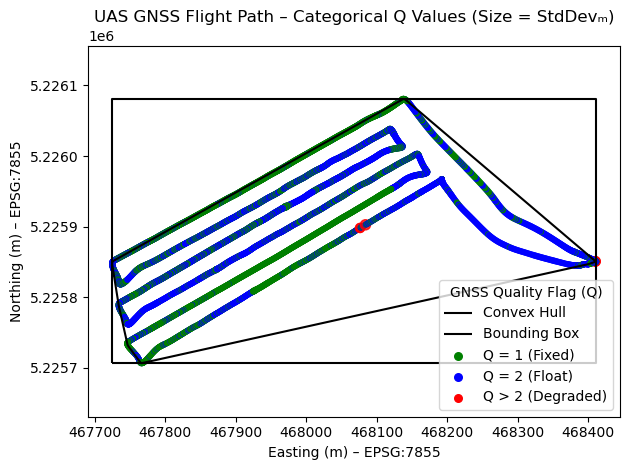

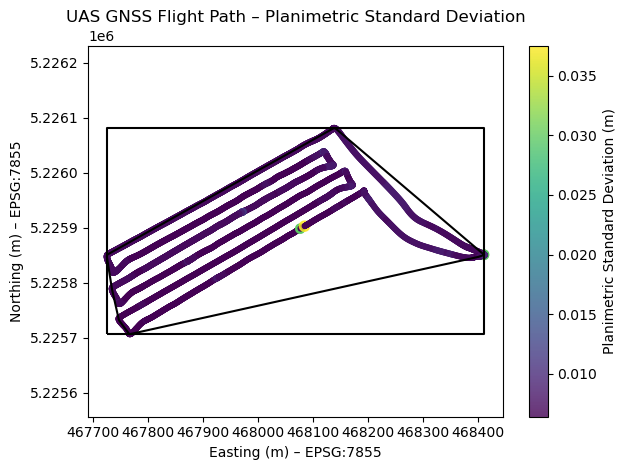

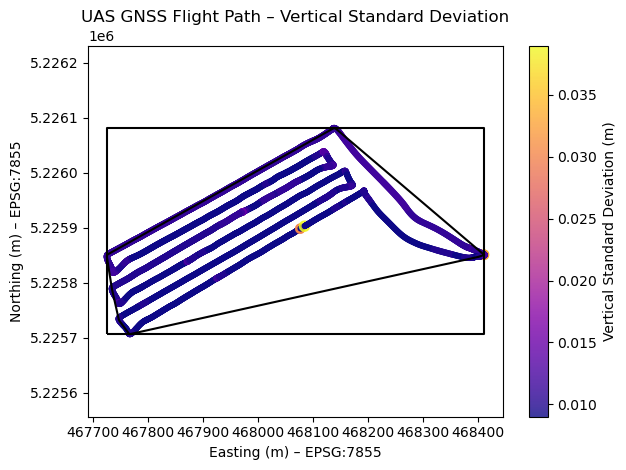

In [11]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# ----------------------------------------------------
# Compute Planimetric Standard Deviation
# ----------------------------------------------------
gdf["SDPlanimetric_m"] = np.sqrt(gdf["SDEast_m"]**2 + gdf["SDNorth_m"]**2)
print(gdf["SDPlanimetric_m"])

# ----------------------------------------------------
# Compute Convex Hull (Shapely 2.0+)
# ----------------------------------------------------
# Note: convex_hull is a PROPERTY, not a function — no ()
convex_hull = gdf.union_all().convex_hull
convex_gdf = gpd.GeoDataFrame(geometry=[convex_hull], crs=gdf.crs)

# ----------------------------------------------------
# Compute Bounding Box
# ----------------------------------------------------
minx, miny, maxx, maxy = gdf.total_bounds
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=gdf.crs)

# ----------------------------------------------------
# Optional: export to GeoPackage
# ----------------------------------------------------
convex_gdf.to_file("uas_flight.gpkg", layer="convex_hull", driver="GPKG")
bbox_gdf.to_file("uas_flight.gpkg", layer="bbox", driver="GPKG")

# ----------------------------------------------------
# Print geometric summaries
# ----------------------------------------------------
print(f"Convex hull area: {convex_hull.area:.2f} m²")
print(f"Convex hull perimeter: {convex_hull.length:.2f} m")
print(f"Bounding box width:  {maxx - minx:.2f} m")
print(f"Bounding box height: {maxy - miny:.2f} m")
print(f"Bounding box area:   {bbox.area:.2f} m²")

# ----------------------------------------------------
# Define Q-colour logic
# ----------------------------------------------------
conditions = [
    gdf["Q"] == 1,
    gdf["Q"] == 2,
    gdf["Q"] > 2
]
choices = ["green", "blue", "red"]
colors = np.select(conditions, choices, default="lightgrey")

# ----------------------------------------------------
# Plot 1: Q Values
# ----------------------------------------------------
plt.figure()
plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=colors,
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Categorical Q Values (Size = StdDevₘ)")
plt.axis("equal")

# Manual legend
plt.scatter([], [], color="green", s=30, label="Q = 1 (Fixed)")
plt.scatter([], [], color="blue", s=30, label="Q = 2 (Float)")
plt.scatter([], [], color="red", s=30, label="Q > 2 (Degraded)")
plt.legend(title="GNSS Quality Flag (Q)", loc="best")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 2: Planimetric SD
# ----------------------------------------------------
plt.figure()
GNSS_plot_2 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDPlanimetric_m"],
    cmap="viridis",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Planimetric Standard Deviation")
plt.axis("equal")

cb = plt.colorbar(GNSS_plot_2)
cb.set_label("Planimetric Standard Deviation (m)")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 3: Vertical SD
# ----------------------------------------------------
plt.figure()
GNSS_plot_3 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDHeight_m"],
    cmap="plasma",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Vertical Standard Deviation")
plt.axis("equal")

cb2 = plt.colorbar(GNSS_plot_3)
cb2.set_label("Vertical Standard Deviation (m)")

plt.tight_layout()
plt.show()


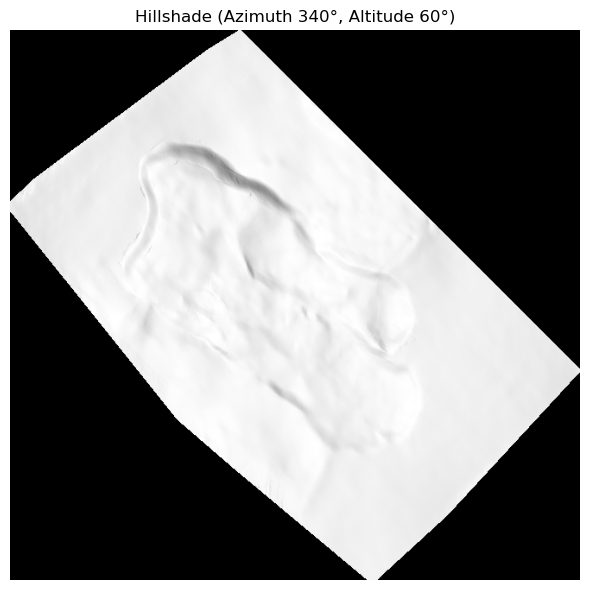

Hillshade raster written: Homehill_2020_Hillshade.tif


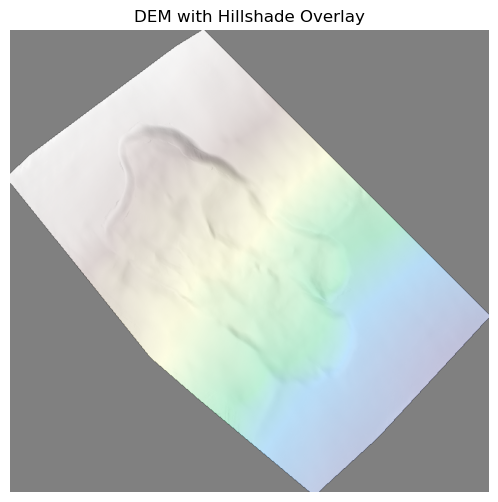

the time to run script was 1.7230889000002207 seconds
the time to run the hillshade was 0.2539382999998452 seconds


In [6]:
import rasterio

time_0 = time.perf_counter()

dem_path = "Homehill_2020_DSM_30cm.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1, masked = True)
    transform = src.transform
    crs = src.crs
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]

azimuth_deg = 340
altitude_deg = 60

azimuth_rad = np.radians(360.0 - azimuth_deg + 90.0)
altitude_rad = np.radians(altitude_deg)

dy, dx = np.gradient(dem.filled(np.nan), pixel_size_y, pixel_size_x)

slope_rad = np.arctan(np.sqrt(dy**2 + dx**2))
aspect_rad = np.arctan2(-dx, dy)
aspect_rad = np.where(aspect_rad < 0, 2 * np.pi + aspect_rad, aspect_rad)

time_1 = time.perf_counter()

# --- Hillshade formula ---
hillshade = (
    np.sin(altitude_rad) * np.cos(slope_rad)
    + np.cos(altitude_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad)
)

# Scale to 0–255 for display
# Clip valid range and replace NaNs with 0 before casting
hillshade_scaled = np.clip(hillshade, 0, 1)
hillshade_scaled = np.where(np.isnan(hillshade_scaled), 0, hillshade_scaled)
hillshade_scaled = (hillshade_scaled * 255).astype(np.uint8)


# --- Plot results ---
plt.figure(figsize=(8,6))
plt.imshow(hillshade_scaled, cmap="gray")
plt.title("Hillshade (Azimuth 340°, Altitude 60°)")
plt.axis("off")
plt.tight_layout()
plt.show()

time_hillshade = time.perf_counter() - time_1
# --- write hillshade to GeoTIFF ---
out_path = "Homehill_2020_Hillshade.tif"
with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=hillshade_scaled.shape[0],
    width=hillshade_scaled.shape[1],
    count=1,
    dtype=np.uint8,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(hillshade_scaled, 1)

print(f"Hillshade raster written: {out_path}")

plt.figure(figsize=(8,6))
plt.imshow(dem, cmap="terrain", alpha=0.5)
plt.imshow(hillshade_scaled, cmap="gray", alpha=0.5)
plt.title("DEM with Hillshade Overlay")
plt.axis("off")
plt.show()

time_script = time.perf_counter() - time_0

print(f"the time to run script was {time_script} seconds")
print(f"the time to run the hillshade was {time_hillshade} seconds")

In [7]:
datadir = Path("C:\Users\User\OneDrive - University of Tasmania\UTAS Surveying\2025 Semester 2\KGG375 Geospatial Data Analytics\Assignments\AT3 Python\KGG375_541_Assignment3_data")
infile = datadir / "Homehill_2020_DSM_30cm.tif"
outfile_TRI = datadi / "Homehill_DEM_TRI.tif"
outfile_mean_vector = datadir / "Homehill_DEM_Mean_Vectorisation.tif"

def raster_tri(inarr, nrows, ncols):

    outarr = np.full((nrows, ncols), np.nan, dtype=np.float64)

    for r in range(1, nrows-1):
        for c in range(1, ncols-1):
            kernel = inarr[r-1:r+2, c-1:c+2]
            centre = kernal [1, 1]
                        neighbours = np.array([kernel[0,0],kernel[0,1], kernel[0,2],
                        kernel[1,0],             kernel[1,2],
                        kernel[2,0],kernel[2,1], kernel[2,2]], dtype=np.float64)
            tri = np.sqrt(np.sum((centre - neighbours)**2))
            outarr[r, c] = tri
    return outarr

def raster_mean_vectorisation(inarr,nrows,ncols):
    outarr = np.full((nrows,ncols),np.nan,dtype=np.float32)
    neighbour_sum = (
            inarr[0:nrows-2,0:ncols-2] + #TL
            inarr[0:nrows-2,1:ncols-1] + #TC
            inarr[0:nrows-2,2:ncols] + #TR
            inarr[1:nrows-1,0:ncols-2] + #ML
            inarr[1:nrows-1,1:ncols-1] + #MC
            inarr[1:nrows-1,2:ncols] + #MR
            inarr[2:nrows,0:ncols-2] + #BL
            inarr[2:nrows,1:ncols-1] + #BC
            inarr[2:nrows,2:ncols] #BR
                        )
    outarr[1:nrows-1,1:ncols-1] = neighbour_sum / 9.0
    return outarr
            

with rasterio.open(infile, nodata=-9999) as dataset:
    dem_arr = dataset.read(1, masked=True)
    nrows, ncols = dem_arr.shape
    #print(dem_arr.shape)
    metadata = dataset.meta.copy()
    tridem = raster_tri(dem_arr, nrows, ncols)
    mean_vector = raster_mean_vectorisation(dem_arr, nrows, ncols)

with rasterio.open(outfile_TRI, 'w', **metadata) as dst:
    dst.write(tridem, 1)
with rasterio.open(outfile_mean_vector, 'w', **metadata) as dst:
    dst.write(mean_vector, 1)
            


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1679177821.py, line 1)